# Qiskit & IBM Quantum Workshop



This tutorial was adapted from notebooks by: _Abby Mitchell - Quantum Developer Advocate (https://abbymitchell.dev) IBM Quantum_ and from _Kevin Sung - Qiskit Researcher, IBM Quantum_

# How to Use this Notebook in your IBM Quantum Lab Account



1. Go to http://qisk.it/SGMeetupJul23 for the workshop resources

<img src="qr-code.png" width=300>

2. Click 'raw' button in GitHub, this will open the notebook file in a new tab

<img src="raw_button.png" width=600>

3. Right click on the raw file and save the file in jupyter notebook format (`.ipynb`)

<img src="save.png" width=600>

4. In IBM Quantum Lab, select upload button on in top left and upload the notebook file

<img src="upload_button.png" width=600>

5. If you didn't save it in `.ipynb` format you can rename the file in the jupyter lab

<img src="rename_button.png" width=600>

6. Now you can open the notebook in your IBM Quantum Lab environment! (note: if you want the images to display in your lab version you will need to download them from the github folder where the notebook is and upload it into your lab folder as well)

<img src="open_notebook.png" width=600>


# Goal: Show you the toolbox - Breadth, not depth!

# Qiskit overview: Main Packages



![](qiskit_overview.png)





# Qiskit 102: Learning to use Qiskit

The fundamental unit you will primarily work with in Qiskit is the `QuantumCircuit` object. The basic workflow to using Qiskit consists of two stages: build and execute. Building involves making different quantum circuits which represent the problem/algorithm you are solving. Executing takes care of the, well, *execution* of those circuits as a job or set of jobs to be run on either real or simulated hardware. After the jobs have been run, the data is collected and must be postprocessed depending on the desired output.  We can do most of this post-processing using Qiskit Runtime.

## Qiskit Runtime Overview
![](runtime-architecture.png)


Qiskit Runtime is a cloud-based quantum computing service developed by IBM. It offers computational primitives to perform foundational quantum computing tasks that use built-in error suppression and mitigation techniques. Primitives can be executed inside of sessions, allowing collections of circuits to be jointly run on a quantum computer without being interrupted by other users’ jobs. The combination of primitives, error suppression / mitigation, and sessions paves the way to efficiently build and execute scalable quantum applications.


---

## Getting Started

The Qiskit packages you will need to get started are:

- `qiskit`
- `qiskit-ibm-runtime`
- `numpy` (optional)
- `matplotlib` (optional)

We'll first walk through the anatomy of a `QuantumCircuit` object and the process of using primitives.


In [ ]:
#make sure your qiskit version is up to date
import qiskit.tools.jupyter
%qiskit_version_table

### Key concepts

**Primitives**

Primitives are base level operations that serve as building blocks for many quantum algorithms and applications. Through these primitives, users can obtain high-fidelity results, without needing detailed hardware knowledge.  This abstraction allows you to write code, using Qiskit algorithms or otherwise, that can run on different quantum hardware or simulators without having to explicitly manage aspects such as compilation, optimization, and error suppression / mitigation. The primitives offered by `qiskit_ibm_runtime <https://qiskit.org/ecosystem/ibm-runtime/apidocs/ibm-runtime.html>`__ add additional options specific to IBM services. See `Introduction to primitives <primitives.html>`__ for further details.

There are currently two primitives defined in Qiskit: Estimator and Sampler.


**Estimator**

The estimator primitive allows you to efficiently calculate and interpret expectation values of quantum operators; the values of interest for many near-term quantum algorithms. You specify circuits that prepare quantum states and then Pauli-basis observables to measure on those states. The estimator can use advanced error suppression and mitigation capabilities to improve the accuracy of the returned expectation values.

**Sampler**

This primitive takes circuits as input and returns a quasi-probability distribution over the measurement outcomes. This generalizes histograms from quantum circuits, allowing for mitigation of readout errors.

**Error suppression / mitigation**

While building a fault-tolerant quantum computation is the ultimate goal, at present, calculations performed on near-term quantum computers are susceptible to noise.  Qiskit Runtime offers a number of methods for preventing errors before they occur (error suppression techniques) and dealing with those that do occur (error mitigation techniques).  

**Session**

A session allows a collection of jobs to be grouped and jointly scheduled by the Qiskit Runtime service, facilitating iterative use of quantum computers without incurring queuing delays on each iteration. This eliminates artificial delays caused by other users’ jobs running on the same quantum device during the session. See `Introduction to sessions <sessions.html>`__ for further details.


# Time for some code! (finally!)

## Simple Examples:

## 0.1 Building the circuit 

The basic element needed for your first program is the QuantumCircuit. We begin by creating a QuantumCircuit comprised of two qubits.

In [3]:
from qiskit import QuantumCircuit

# Create a Quantum Circuit acting on a quantum register of two qubits
circ = QuantumCircuit(2)
print(circ)

     
q_0: 
     
q_1: 
     


## 0.2 Adding Gates

We can then add gates to the circuit. We start with a Hadamard gate acting on qubit $0$ and then add a $C_X$ (CNOT) gate using $0$ as the control qubit and $1$ as the target. 

In [8]:
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)

## 0.3 Circuit Visualization

You can visualize your circuit using the `QuantumCircuit.draw()` method, which plots the circuit in the form found in many textbooks.

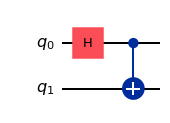

In [9]:
circ.draw('mpl', style="iqp")

In [10]:
#One can also draw this as an ascii drawing
circ.draw()

┌───┐     
q_0: ┤ H ├──■──
     └───┘┌─┴─┐
q_1: ─────┤ X ├
          └───┘


A few of the basic gates which can be added to a quantum circuit are the:

* Pauli $X$, $Y$, $Z$ gates - `.x()` `.y()`
* Hadamard $H$ gate 
* $S$ (or $\pi/2$) phase gate
* $T$ (or $\pi/4$) phase gate
* Controlled-NOT (or Controlled-$X$) gate - `.cx`
* Controlled-$H$ gate - `.ch`
* CCX or Toffoli gate - `.ccx`

among many others.  See the documentation for the full list of supported gates.

# 1.0 Using Primitives

There are two main approaches within Qiskit to execute and measure your quantum circuits called `Primitives`.  The first is the `Estimator` which computes the expectation values of observables.  Users generally specify a list of circuits, observables, and a few other optional configurations, with which the program can efficiently evaluate expectation values and variances.  The second is the `Sampler` primitive which with calculate the probabilities (or quasi-probabilities if using error mitigation) of bitstrings from quantum circuits.

Primitives work most effectively when they are supported by both Qiskit and the backend provider. The Qiskit module qiskit.primitives provides the required support on the Qiskit side, and providers like IBM Qiskit Runtime enable access to appropriate backends through native implementations of their own primitives.

We'll learn to use these objects by utilizing a small example circuit which will fully entangle two qubits together and then measure them.

 we'll demonstrate using the `Sampler` primitive (both the `qiskit.primitives` version as well as the managed `qiskit-ibm-runtime` version).  Recall the `Sampler` is primarily useful for when you want to measure (quasi-)probability distributions.  We'll use the same quantum circuit, `qc` which prepares a Bell state (i.e., fully entangle two-qubits together).


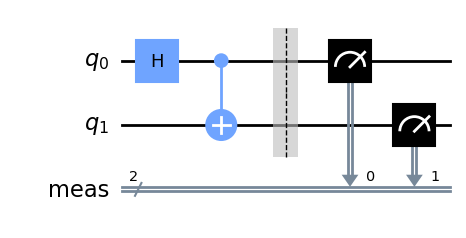

In [6]:
from qiskit.primitives import Sampler

#Instantiate a new Sampler object
sampler = Sampler()


#We'll also need to add measurement
circ = QuantumCircuit(2)

circ.h(0)
circ.cx(0, 1)
# Insert measurements on all qubits
circ.measure_all()
circ.draw('mpl', style='iqp')


In [7]:
# Now run the job and examine the results
sampler_job = sampler.run(circ)
result = sampler_job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{0: 0.4999999999999999, 3: 0.4999999999999999}], metadata=[{}])
  > Quasi-probability distribution (integer): {0: 0.4999999999999999, 3: 0.4999999999999999}
  > Quasi-probability distribution (bits): {'00': 0.4999999999999999, '11': 0.4999999999999999}
  > Metadata: {}


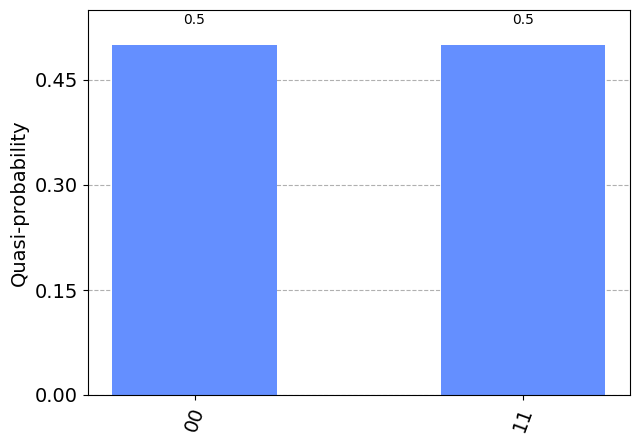

In [8]:
from qiskit.tools.visualization import plot_distribution

prob_distribution = sampler_job.result().quasi_dists[0].binary_probabilities()

plot_distribution(prob_distribution)


---


Next we'll use the Runtime Sampler to run our circuit on a backend.  Recall that we still need to specify an `IBMBackend` object through the `QisktiRuntimeService`.

In [19]:
from qiskit_ibm_runtime import Sampler
 
#Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

#We will use the 127-qubit ibm_nazca backend
backend = service.get_backend('ibm_nazca')

# sampler = Sampler(backend=backend)
sampler = Sampler(session=session)

In [20]:
job = sampler.run(circ)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cnme5geb4zk00082a4hg
>>> Session ID: cnme59db4zk00082a4h0
>>> Job Status: JobStatus.QUEUED


We can also obtain a previous result in the same way as the `Estimator`.

In [21]:
# Use a job id from a previous result
job = service.job("cncfm89hga30008f2660")
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.DONE


In [22]:
result = job.result()
print(f"Job Result:\n>>> {result}")
print(f"  > Quasi-probability distribution (integer): {result.quasi_dists[0]}")
print(f"  > Quasi-probability distribution (bits): {result.quasi_dists[0].binary_probabilities(2)}")
print(f"  > Metadata: {result.metadata[0]}")

Job Result:
>>> SamplerResult(quasi_dists=[{0: 0.500216756192343, 1: 0.018130479836529, 2: -0.009745479238165, 3: 0.491398243209293}], metadata=[{'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.3906290541317785, 'readout_mitigation_time': 0.036765546072274446}])
  > Quasi-probability distribution (integer): {0: 0.500216756192343, 1: 0.018130479836529, 2: -0.009745479238165, 3: 0.491398243209293}
  > Quasi-probability distribution (bits): {'00': 0.5002167561923428, '01': 0.018130479836528622, '10': -0.009745479238164975, '11': 0.49139824320929343}
  > Metadata: {'shots': 4000, 'circuit_metadata': {}, 'readout_mitigation_overhead': 1.3906290541317785, 'readout_mitigation_time': 0.036765546072274446}


We're also able to visualize the probability distribution of this circuit on a histogram.  Plotting this gives us a quick visual tool to help us understand what the states with the highest measurement probability are. 

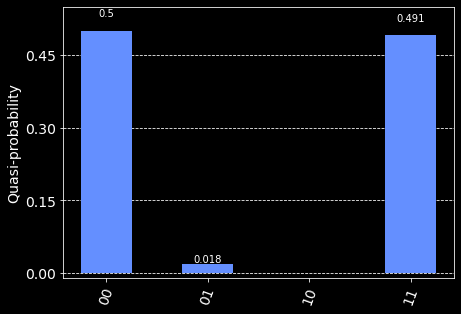

In [25]:
from qiskit.visualization import plot_distribution

import matplotlib.pyplot as plt
plt.style.use('dark_background')

#plot_distribution(result.quasi_dists[0])
plot_distribution(result.quasi_dists[0].binary_probabilities(2))

### 1.1.1 Using the Runtime Estimator

A subtle difference here is that there are actually *two* `Estimator` objects in our environment.  One within `qiskit.primitives` and one within our ecosystem package `qiskit-ibm-runtime`.  The Runtime Primitives are best used for submitting jobs to a backend while the Qiskit Primitives are useful for doing sanity checks on your workflows and ensuring everything is working as intended.

We'll now execute this circuit using the Runtime Service.  To do so, we'll need to initialize a `QiskitRuntimeService` object and select a backend to run the circuit on.  For this example we'll use the 127-qubit `ibm_nazca` backend.  We'll then instantiate a new `Estimator` object from the Runtime package. We have two options here: we can instantiate the `Estimator` object with the `backend`, *or* we can start a `Session` that we can send multiple jobs to without waiting in the queue for subsequent jobs, and pass the `Session` object to the `Estimator`.



In [14]:
from qiskit_ibm_runtime import Estimator, Session

#Initialize a QiskitRuntimeService object
service = QiskitRuntimeService()

#We will use the 127-qubit ibm_nazca backend
backend = service.get_backend('ibm_nazca')

# create a Runtime session for efficient execution (optional)
session = Session(service=service, backend=backend)

# estimator = Estimator(backend=backend) 
estimator = Estimator(session=session)

The access your institution has obtained will determine which backends are available to you.  You can list all of your available backends and obtain information about its status, the number of pending jobs, and detailed configuration information.

In [15]:
#Here we can get some status information about the backend
status = backend.status()
is_operational = status.operational
jobs_in_queue = status.pending_jobs
print('Operational?: {} \n Jobs in Queue: {}\n'.format(is_operational, jobs_in_queue))


# We can also obtain some configuration information
config = backend.configuration()
print(64*"#","\nConfiguration for: {}, version: {}".format(config.backend_name, config.backend_version))
print("  Number of Qubits: {}".format(config.n_qubits))
print("  Basis Gates: {}".format(config.basis_gates))
print("  OpenPulse Enabled: {}".format(config.open_pulse))

Operational?: True 
 Jobs in Queue: 17

################################################################ 
Configuration for: ibm_nazca, version: 1.0.15
  Number of Qubits: 127
  Basis Gates: ['ecr', 'id', 'rz', 'sx', 'x']
  OpenPulse Enabled: True



---

Now we'll run our job on the hardware.  We can get also get some information about its status while we wait

In [16]:
job = estimator.run(qc, observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cnme59db4zk00082a4h0
>>> Session ID: cnme59db4zk00082a4h0
>>> Job Status: JobStatus.QUEUED


We can also check on the status on the online platform: [https://quantum-computing.ibm.com/jobs](https://quantum-computing.ibm.com/jobs)

Another useful feature is to be able to pull data from previous jobs you've run if you're running analysis on your results in a separate notebook or python script.  All that's needed is the Job ID

In [ ]:
# Use a job id from a previous result
job = service.job("cncfk64xswgg0087jbj0")
print(f">>> Job Status: {job.status()}")

In [ ]:
#Examine our results once the job has completed
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

## 2. Transpilation & Error Mitigation

Oftentimes, the quantum circuits constructed for utility scale algorithms are not well optimized to run on noisy quantum hardware.  In fact, it may even be important to post-process your results using error mitigation techniques.  Fortunately, there are a few ways to implement both error mitigation as well as optimizations of your quantum circuits.

The first is to simply set a few Runtime configuration options; specifically the `optimization_level` and `resilience_level`.  These are both managed and included in a Runtime Primitive using the `Options` object.

The options for `optimization_level` are:

| Optimization Level | Estimator & Sampler |
| :--- | :--- |
| 0 | No optimization: typically used for hardware characterization or debugging <br />    - Basis translation <br /> - Layout (`TrivialLayout`: virtual -> physical)  <br /> - Routing: `StochasticSwap` |
| 1, 2, 3 | Light optimization: (TODO: update this w/ current docs) <br /> - Layout (trivial → vf2 → SabreLayout if routing is required) <br /> - Routing (SabreSwap if needed) <br /> - 1Q gate optimization <br /> - Error suppression: dynamical decoupling |


And the options for `resilience_level` are different between the `Sampler` and `Estimator` primitives

| Resilience Level | Definition | Estimator | Sampler |
| :--- | :--- | :--- | :---
|0 | No mitigation	| None | None |
|1 [Default] |	Minimal mitigation costs: Mitigate error associated with readout errors | Twirled Readout Error eXtinction (TREX interpreted-text readout errors )	| M3 |
| 2 | Medium mitigation costs. Typically reduces bias in estimators, but is not guaranteed to be zero bias. | Zero Noise Extrapolation (ZNE interpreted-text) |	- |
| 3| Heavy mitigation with layer sampling. Theoretically expected to deliver zero bias estimators. | Probabilistic Error cancelation (PEC interpreted-text)	| - |


Let's look at a quick example

In [20]:
from qiskit_ibm_runtime import Options


# To set our resilience and optimization level we need to create this `Options` object
options = Options()
options.resilience_level = 2
options.optimization_level = 3

In [22]:
# We'll prepare the same example circuit as before
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc = QuantumCircuit(qr, cr)
# we can also write "qc = QuantumCircuit(2,2)"

#Add the hadamard and CNOT gates to the circuit
qc.h(0)
qc.cx(0, 1)


# We'll also instantiate a new Runtime Estimator() object
# estimator = Estimator(options=options, backend=backend)
estimator = Estimator(options=options, session=session)

# and use the same observable as before
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])


In [23]:
job = estimator.run(circuits=qc, observables=observable)
print(f">>> Job ID: {job.job_id()}")
print(f">>> Session ID: {job.session_id}")
print(f">>> Job Status: {job.status()}")

>>> Job ID: cncfmyvnekzg008nr2rg
>>> Session ID: cncfk64xswgg0087jbj0
>>> Job Status: JobStatus.QUEUED


In [ ]:
# Use a job id from a previous result
job = service.job("cn9ee48q2k7g0088qvzg")
print(f">>> Job Status: {job.status()}")

In [ ]:
#Examine our results once the job has completed
result = job.result()
print(f">>> {result}")
print(f"  > Expectation value: {result.values[0]}")
print(f"  > Metadata: {result.metadata[0]}")

In [1]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright

In [1]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright